In [1]:
import os

experiment_path = './data/Fit Experiment'

if not os.path.exists(experiment_path):
    os.makedirs(experiment_path)

In [3]:
from map_maker import cluttered_map, save_map
from Turtlebot_Kinematics import unicycleKin
from environment import Environment, load_ENV
from Runner import ControllMode, Runner
from pso_controller import Multi_PSO_Controller
from dwa_controller import DWA_Controller

kinematic = unicycleKin()
run_num = 31
dt = 0.1
max_index = None

# map parameters
map_obs = 8
map_size = 50
map_unknown = True
map_name = f"cluttered_{map_obs}obs_{map_size}x{map_size}_{'unknown' if map_unknown else 'known'}"

for i in range(run_num):
    # create run foder
    run_path = f"{experiment_path}/{i}"
    if not os.path.exists(run_path):
        os.makedirs(run_path)

    # create and save map
    run_map = cluttered_map(map_obs, map_size, map_unknown)
    map_path = f"{run_path}/{map_name}"
    save_map(run_map, map_name, run_path)

    # run and save long MultiPSO data
    ENV = Environment.from_dict(run_map, kinematic, record=True)
    controller = Multi_PSO_Controller(5, kinematic, 10, 0.75, 10)
    controller.goal_exp = 0.8
    if max_index is None:
        max_index = ENV.goal_travel_time / dt + 200
    else: assert max_index == ENV.goal_travel_time / dt + 200
    Run = Runner(
        ENV, 
        ControllMode.MultiPSO, 
        controller, 
        max_step = max_index,
        dt = dt,
        save_path= f"{run_path}/08_data"
    )
    Run.loop()

    ENV = Environment.from_dict(run_map, kinematic, record=True)
    controller = Multi_PSO_Controller(5, kinematic, 10, 0.75, 10)
    controller.goal_exp = 1.0
    if max_index is None:
        max_index = ENV.goal_travel_time / dt + 200
    else: assert max_index == ENV.goal_travel_time / dt + 200
    Run = Runner(
        ENV, 
        ControllMode.MultiPSO, 
        controller, 
        max_step = max_index,
        dt = dt,
        save_path= f"{run_path}/10_data"
    )
    Run.loop()

    ENV = Environment.from_dict(run_map, kinematic, record=True)
    controller = Multi_PSO_Controller(5, kinematic, 10, 0.75, 10)
    controller.goal_exp = 1.2
    if max_index is None:
        max_index = ENV.goal_travel_time / dt + 200
    else: assert max_index == ENV.goal_travel_time / dt + 200
    Run = Runner(
        ENV, 
        ControllMode.MultiPSO, 
        controller, 
        max_step = max_index,
        dt = dt,
        save_path= f"{run_path}/12_data"
    )
    Run.loop()


# 1
stepping (15.0, 0.9)
offset [0. 0. 0.]
# 2
stepping (14.597808731109515, -0.08404093923108458)
offset [0. 0. 0.]
# 3
stepping (14.66956932710826, -0.3606285231293776)
offset [0. 0. 0.]
# 4
stepping (14.713626750160492, -0.36663266525816923)
offset [0. 0. 0.]
# 5
stepping (14.740510541679564, -0.3631709373365731)
offset [0. 0. 0.]
# 6
stepping (14.75609223828896, -0.327244096037208)
offset [0. 0. 0.]
# 7
stepping (14.872470620932749, -0.46385348855804087)
offset [0. 0. 0.]
# 8
stepping (14.810136093467161, -0.27078916855624474)
offset [0. 0. 0.]
# 9
stepping (15.0, -0.3524896474776911)
offset [0. 0. 0.]
# 10
stepping (14.669174249739289, -0.08834246772721199)
offset [0. 0. 0.]
# 11
stepping (14.77322739570499, -0.09730464992873775)
offset [0. 0. 0.]
# 12
stepping (14.606799962357801, 0.053793032513771585)
offset [0. 0. 0.]
# 13
stepping (14.493913819386856, 0.10134746420111806)
offset [0. 0. 0.]
# 14
stepping (14.400452453335372, 0.11583930158348295)
offset [0. 0. 0.]
# 15
stepping 

In [4]:
import numpy as np

max_index = int(np.ceil(max_index))
print("Max_index:", max_index)


Max_index: 567


In [5]:
import pandas
from pandas import DataFrame
import matplotlib.pyplot as plt

In [6]:
def fill_df(df, length, di):
    index = df.index[-1]
    last_loc = df.iloc[-1]
    while len(df) < length:
        index += di
        df.loc[index] = last_loc
    return df

def build_loc(goal_dists, obst_dists):
    return {
        "goal_dists": goal_dists,
        "obst_dists": obst_dists
    }

In [7]:

df_08 = DataFrame(columns=["goal_dists", "obst_dists"])
df_10 = DataFrame(columns=["goal_dists", "obst_dists"])
df_12 = DataFrame(columns=["goal_dists", "obst_dists"])

def append_to_total_df(total_df, file_name, max_index, dt):
    df = pandas.read_hdf(file_name)
    goal_dists = fill_df(df["goal_dist"], max_index, dt)
    obst_dists = fill_df(df["obst_dist"], max_index, dt)
    total_df.loc[i] = build_loc(goal_dists, obst_dists)

for i in range(run_num):
    append_to_total_df(df_08, f"{experiment_path}/{i}/08_data.h5", max_index, dt)
    append_to_total_df(df_10, f"{experiment_path}/{i}/10_data.h5", max_index, dt)
    append_to_total_df(df_12, f"{experiment_path}/{i}/12_data.h5", max_index, dt)
    



In [8]:
def get_eval_arrays(total_df, max_index):
    print(total_df.iloc[0])
    avg_goal = list([np.average([total_df.iloc[i]["goal_dists"].iloc[j] for i in range(run_num)])for j in range(max_index)])
    avg_obst = list([np.average([total_df.iloc[i]["obst_dists"].iloc[j] for i in range(run_num)])for j in range(max_index)])
    min_obst = list([np.min([total_df.iloc[i]["obst_dists"].iloc[j] for i in range(run_num)])for j in range(max_index)])
    return avg_goal, avg_obst, min_obst


goal_dists    0.0       0.000000
0.1       0.150324
0.2     ...
obst_dists    0.0     3.125000
0.1     3.218623
0.2     3.30...
Name: 0, dtype: object
goal_dists    0.0       0.000000
0.1       0.093965
0.2     ...
obst_dists    0.0     3.125000
0.1     3.216097
0.2     3.30...
Name: 0, dtype: object
goal_dists    0.0      0.000000
0.1      0.367332
0.2      0...
obst_dists    0.0     3.125000
0.1     3.187271
0.2     3.25...
Name: 0, dtype: object


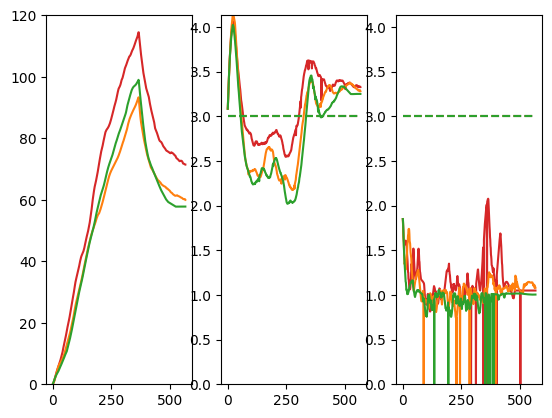

In [9]:
def plot_eval_row(axs, total_df, color="blue"):
    avg_goal, avg_obst, min_obst = get_eval_arrays(total_df, max_index)
    axs[0].plot(avg_goal, color=color)
    axs[1].plot(avg_obst, color=color)
    axs[1].plot([3]*len(avg_obst), linestyle="--")
    axs[2].plot(min_obst, color=color) 
    axs[2].plot([3]*len(min_obst), linestyle="--")
    axs[2].set_ylim(top = axs[1].get_ylim()[1])
    for ax in axs:
        ax.set_ylim(bottom = 0.0)

fig, axs = plt.subplots(1,3)
plot_eval_row(axs, df_08, "tab:red")
plot_eval_row(axs, df_10, "tab:orange")
plot_eval_row(axs, df_12, "tab:green")
